In [1]:
import pickle
import pandas as pd
def load_data(picklefile):
    f = open(picklefile, "rb")
    dict = pickle.load(f)
    f.close()
    return dict["Perth_Airport"], dict["Perth_Metro"]
PerthA_df, PerthM_df = load_data("temperatures.pkl")

In [2]:
PerthA_df.columns = ["min", "max"]
PerthA_df

,min,max
date,,
1944-06,8.1,20.4
1944-07,7.7,18.3
1944-08,7.1,19.5
1944-09,7.9,20.3
1944-10,10.5,24.6
...,...,...
2024-04,14.4,28.9
2024-05,13.1,25.4
2024-06,10.1,20.5


In [3]:
PerthM_df.columns = ["min", "max"]
PerthM_df

,min,max
date,,
1994-01,17.2,29.2
1994-02,16.7,29.0
1994-03,16.5,30.3
1994-04,14.1,26.8
1994-05,10.9,22.8
...,...,...
2024-04,14.4,28.2
2024-05,12.9,24.9
2024-06,10.1,20.3


In [4]:
def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    # an inner function to do the splitting
    def split_inputs_and_targets(tf_ds):
        return tf_ds[:, :-targets_length], tf_ds[:, -targets_length:]
    if batch_size == -1:
        batch_size = df.shape[0]
    return tf.keras.utils.timeseries_dataset_from_array(
        tf.convert_to_tensor(df, dtype=tf.float32),
        targets = None,
        sequence_length = inputs_length + targets_length,
        batch_size = batch_size,
        shuffle = shuffle,
        seed = seed
    ).map(split_inputs_and_targets)

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit and transform the training data
PerthA_scaled = scaler.fit_transform(PerthA_df)
PerthA_df_scaled = pd.DataFrame(PerthA_scaled, index=PerthA_df.index, columns=PerthA_df.columns)

# Apply the same transformation to validation and test data
PerthM_scaled = scaler.transform(PerthM_df)
PerthM_df_scaled = pd.DataFrame(PerthM_scaled, index=PerthM_df.index, columns=PerthM_df.columns)


In [6]:
import tensorflow as tf
# For validation set
validation_df = PerthM_df_scaled.loc['1994-01':'2013-12']

# For test set
test_df = PerthM_df_scaled.loc['2014-01':]

# For training dataset
train_ds = split_data(
    df=PerthA_df_scaled,
    inputs_length=72,
    targets_length=12,
    batch_size=32,
    shuffle=True,
    seed=42
)

# For validation dataset
val_ds = split_data(
    df=validation_df,
    inputs_length=72,
    targets_length=12,
    batch_size=-1,
    shuffle=False
)

# For test dataset
test_ds = split_data(
    df=test_df,
    inputs_length=72,
    targets_length=12,
    batch_size=-1,
    shuffle=False
)

# For training dataset
for X_train_batch, y_train_batch in train_ds.take(1):
    print('X_train shape:', X_train_batch.shape)
    print('y_train shape:', y_train_batch.shape)


X_train shape: (32, 72, 2)
y_train shape: (32, 12, 2)


2024-10-25 00:46:49.641258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Assuming 'train_ds' is your training dataset
print("Training Dataset Minibatches:")
for i, (X_batch, y_batch) in enumerate(train_ds):
    print(f"Minibatch {i+1}:")
    print(f"  X_batch shape: {X_batch.shape}")
    print(f"  y_batch shape: {y_batch.shape}")
    # Optionally, print a small sample from the batch
    print("  Sample X_batch data (first sequence):")
    print(X_batch[0].numpy())
    print("  Sample y_batch data (first sequence):")
    print(y_batch[0].numpy())
    print("-" * 50)


Training Dataset Minibatches:
Minibatch 1:
  X_batch shape: (32, 72, 2)
  y_batch shape: (32, 12, 2)
  Sample X_batch data (first sequence):
[[0.27878788 0.37313432]
 [0.3939394  0.52238804]
 [0.6363636  0.6965174 ]
 [0.8424242  0.9004975 ]
 [0.75757575 0.8159204 ]
 [0.6666667  0.6666667 ]
 [0.38181818 0.3283582 ]
 [0.23636363 0.33830845]
 [0.18787879 0.14925373]
 [0.09696969 0.06965174]
 [0.16969697 0.10447761]
 [0.26666668 0.27860695]
 [0.2969697  0.37810946]
 [0.43030304 0.56218904]
 [0.6363636  0.6666667 ]
 [0.8848485  0.96517414]
 [0.72121215 0.8159204 ]
 [0.5272727  0.5920398 ]
 [0.56363636 0.5472637 ]
 [0.42424244 0.37313432]
 [0.27878788 0.1641791 ]
 [0.06666667 0.08457711]
 [0.16969697 0.15422885]
 [0.2060606  0.1840796 ]
 [0.23030303 0.20895523]
 [0.47272727 0.44278607]
 [0.7090909  0.70149255]
 [0.8        0.76119405]
 [0.8484849  0.74626863]
 [0.7878788  0.71144277]
 [0.53333336 0.46268657]
 [0.47272727 0.20895523]
 [0.27878788 0.06965174]
 [0.29090908 0.03980099]
 [0.27272

2024-10-25 00:46:49.699264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# For validation dataset
print("Validation Dataset:")
for i, (X_val, y_val) in enumerate(val_ds):
    print(f"Batch {i+1}:")
    print(f"  X_val shape: {X_val.shape}")
    print(f"  y_val shape: {y_val.shape}")
    # Optionally, print sample data
    print("  Sample X_val data (first sequence):")
    print(X_val[0].numpy())
    print("  Sample y_val data (first sequence):")
    print(y_val[0].numpy())
    print("-" * 50)

# For test dataset
print("Test Dataset:")
for i, (X_test, y_test) in enumerate(test_ds):
    print(f"Batch {i+1}:")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  y_test shape: {y_test.shape}")
    # Optionally, print sample data
    print("  Sample X_test data (first sequence):")
    print(X_test[0].numpy())
    print("  Sample y_test data (first sequence):")
    print(y_test[0].numpy())
    print("-" * 50)


Validation Dataset:
Batch 1:
  X_val shape: (157, 72, 2)
  y_val shape: (157, 12, 2)
  Sample X_val data (first sequence):
[[ 0.74545455  0.6467662 ]
 [ 0.7151515   0.6368159 ]
 [ 0.7030303   0.70149255]
 [ 0.55757576  0.5273632 ]
 [ 0.36363637  0.3283582 ]
 [ 0.23030303  0.11940298]
 [ 0.26666668  0.11940298]
 [ 0.2         0.1641791 ]
 [ 0.2969697   0.2636816 ]
 [ 0.37575758  0.33333334]
 [ 0.58181816  0.53731346]
 [ 0.73333335  0.6766169 ]
 [ 0.8424242   0.75124377]
 [ 0.8181818   0.76119405]
 [ 0.73333335  0.73134327]
 [ 0.47878787  0.43283582]
 [ 0.27272728  0.23383084]
 [ 0.13939394  0.08457711]
 [ 0.25454545  0.08955224]
 [ 0.26060605  0.1442786 ]
 [ 0.3212121   0.21393035]
 [ 0.4121212   0.3681592 ]
 [ 0.5212121   0.4079602 ]
 [ 0.6909091   0.5721393 ]
 [ 0.73333335  0.70149255]
 [ 0.8484849   0.91542286]
 [ 0.6606061   0.5870647 ]
 [ 0.53333336  0.47761193]
 [ 0.3030303   0.3432836 ]
 [ 0.3030303   0.15920398]
 [ 0.34545454  0.09452736]
 [ 0.23030303  0.09950249]
 [ 0.33939394

2024-10-25 00:46:49.736618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-25 00:46:49.750612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# For training dataset
num_train_batches = sum(1 for _ in train_ds)
print(f"Total number of minibatches in training dataset: {num_train_batches}")


Total number of minibatches in training dataset: 28


2024-10-25 00:46:49.791339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


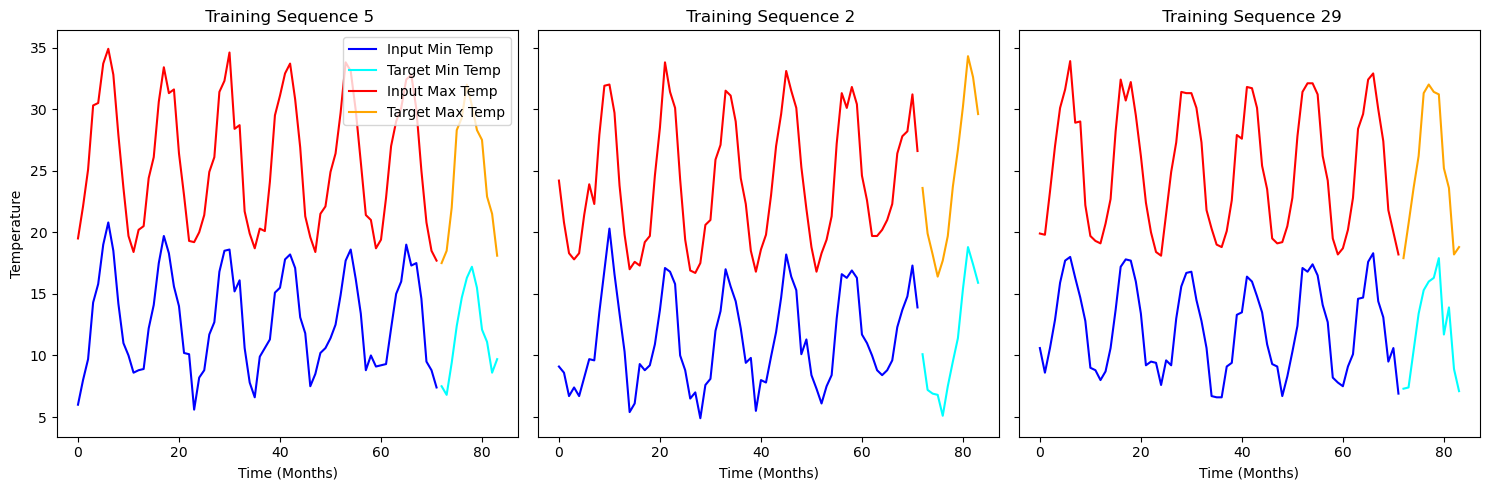

2024-10-25 00:46:50.224657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


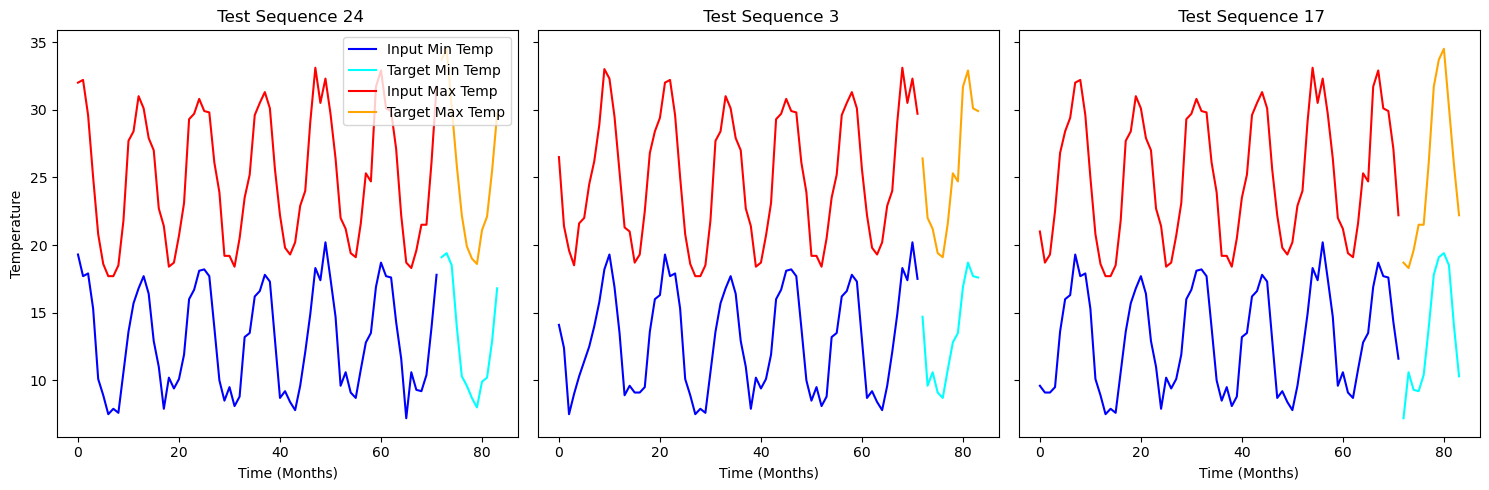

2024-10-25 00:46:50.370833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

def display_temperatures(X, y, num_samples=3, model_name='', predicted=None, title_prefix='', inverse_scaler=None):
    """
    Displays temperature sequences from inputs and targets (and optionally predictions).
    
    Parameters:
    - X: NumPy array of input sequences, shape (num_sequences, input_length, num_features).
    - y: NumPy array of target sequences, shape (num_sequences, target_length, num_features).
    - num_samples: Number of sequences to display (default is 3).
    - predicted: (Optional) NumPy array of predicted sequences, same shape as y.
    - title_prefix: (Optional) Prefix for subplot titles.
    - inverse_scaler: (Optional) Scaler object with inverse_transform method to revert scaling.
    """
    num_sequences = X.shape[0]
    indices = random.sample(range(num_sequences), num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5), sharey=True)
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        # Combine input and target sequences for plotting
        input_seq = X[idx]
        target_seq = y[idx]
        if predicted is not None:
            predicted_seq = predicted[idx]
        else:
            predicted_seq = None

        # Optionally inverse transform the data
        if inverse_scaler is not None:
            input_seq_full = np.concatenate([input_seq, target_seq], axis=0)
            input_seq_full = inverse_scaler.inverse_transform(input_seq_full)
            input_seq = input_seq_full[:len(input_seq)]
            target_seq = input_seq_full[len(input_seq):len(input_seq) + len(target_seq)]
            if predicted_seq is not None:
                predicted_seq_full = np.concatenate([input_seq, predicted_seq], axis=0)
                predicted_seq_full = inverse_scaler.inverse_transform(predicted_seq_full)
                predicted_seq = predicted_seq_full[len(input_seq):len(input_seq) + len(predicted_seq)]
        
        # Time axes
        input_time = np.arange(len(input_seq))
        target_time = np.arange(len(input_seq), len(input_seq) + len(target_seq))
        
        # Plot minimum temperatures
        ax.plot(input_time, input_seq[:, 0], label='Input Min Temp', color='blue')
        if len(target_seq) > 1:
            ax.plot(target_time, target_seq[:, 0], label='Target Min Temp', color='cyan')
        else:
            ax.plot(target_time, target_seq[:, 0], 'o', label='Target Min Temp', color='cyan')
        if predicted_seq is not None:
            if len(predicted_seq) > 1:
                ax.plot(target_time, predicted_seq[:, 0], label='Predicted Min Temp', linestyle='--', color='navy')
            else:
                ax.plot(target_time, predicted_seq[:, 0], 'x', label='Predicted Min Temp', color='navy', markersize=8)
        
        # Plot maximum temperatures
        ax.plot(input_time, input_seq[:, 1], label='Input Max Temp', color='red')
        if len(target_seq) > 1:
            ax.plot(target_time, target_seq[:, 1], label='Target Max Temp', color='orange')
        else:
            ax.plot(target_time, target_seq[:, 1], 'o', label='Target Max Temp', color='orange')
        if predicted_seq is not None:
            if len(predicted_seq) > 1:
                ax.plot(target_time, predicted_seq[:, 1], label='Predicted Max Temp', linestyle='--', color='darkred')
            else:
                ax.plot(target_time, predicted_seq[:, 1], 'x', label='Predicted Max Temp', color='darkred', markersize=8)
        
        ax.set_title(f'{model_name} {title_prefix} Sequence {idx}')
        ax.set_xlabel('Time (Months)')
        if i == 0:
            ax.set_ylabel('Temperature')
            ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage with training data
for X_train_batch, y_train_batch in train_ds.take(1):
    display_temperatures(X_train_batch, y_train_batch, title_prefix='Training', inverse_scaler=scaler)

# Example usage with test data
for X_test_batch, y_test_batch in test_ds.take(1):
    display_temperatures(X_test_batch, y_test_batch, title_prefix='Test', inverse_scaler=scaler)


In [11]:
def prepare_datasets(input_length, target_length, batch_size_train=32):
    """
    Prepares training, validation, and test datasets with specified input and target lengths.

    Parameters:
    - input_length: Length of input sequences.
    - target_length: Length of target sequences.
    - batch_size_train: Batch size for the training dataset.

    Returns:
    - train_ds, val_ds, test_ds: TensorFlow datasets.
    """
    # Training dataset: Use entire Perth Airport dataframe
    train_ds = split_data(
        df=PerthA_df_scaled,
        inputs_length=input_length,
        targets_length=target_length,
        batch_size=batch_size_train,
        shuffle=True,
        seed=42
    )

    # Validation dataset: Perth Metro from '1994-01' to '2013-12'
    validation_df = PerthM_df_scaled.loc['1994-01':'2013-12']
    val_ds = split_data(
        df=validation_df,
        inputs_length=input_length,
        targets_length=target_length,
        batch_size=-1,
        shuffle=False
    )

    # Test dataset: Perth Metro from '2014-01' onward
    test_df = PerthM_df_scaled.loc['2014-01':]
    test_ds = split_data(
        df=test_df,
        inputs_length=input_length,
        targets_length=target_length,
        batch_size=-1,
        shuffle=False
    )

    return train_ds, val_ds, test_ds


In [12]:
def train_model(model, train_ds, val_ds, epochs=50, isCompare=False):
    """
    Trains the model and plots learning curves.

    Parameters:
    - model: Compiled TensorFlow model.
    - train_ds: Training dataset.
    - val_ds: Validation dataset.
    - epochs: Number of epochs to train.
    - model_name: Name or description of the model to use in the plot title.

    Returns:
    - history: Training history object.
    """
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=1
    )

    if isCompare==False:
        # Plot learning curves
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.title(f'Learning Curves for {model.name}')
        plt.show()

    return history


In [13]:
def evaluate_and_visualize(model, test_ds, num_samples=3, model_type='model1'):
    """
    Evaluates the model on the test set and visualizes predictions.

    Parameters:
    - model: Trained model.
    - test_ds: Test dataset.
    - num_samples: Number of sequences to visualize.
    - model_type: Type of the model ('model1', 'model2', 'model3').

    Returns:
    - test_mae: MAE on the test set.
    """
    # Extract inputs and targets from the test dataset
    for X_test, y_test in test_ds.take(1):
        pass  # X_test and y_test are obtained

    # Convert X_test and y_test to NumPy arrays if they are tensors
    X_test = X_test.numpy() if isinstance(X_test, tf.Tensor) else X_test
    y_test = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test

    # Make predictions
    if model_type == 'model2b':
        # Predict one step ahead in a loop for the target sequence length
        target_length = y_test.shape[1]  # Should be 12 for this evaluation
        y_preds = []
        X_input = X_test.copy()
        for i in range(target_length):
            y_pred = model.predict(X_input)
            y_pred = y_pred.reshape(-1, 1, X_input.shape[2])  # Ensure correct shape
            y_preds.append(y_pred)
            # Append prediction to input and remove oldest time step
            # X_input = np.concatenate([X_input[:, 1:, :], y_pred], axis=1)
            X_input = np.concatenate([X_input, y_pred], axis=1)
        y_pred = np.concatenate(y_preds, axis=1)
    else:
        # Direct prediction
        y_pred = model.predict(X_test)
        if model_type == 'model3':
            y_pred = y_pred  # Output is already in the correct shape
        else:
            y_pred = y_pred.reshape(y_test.shape)

    # Evaluate MAE
    test_mae = np.mean(np.abs(y_test - y_pred))
    # _ , test_mae = model.evaluate(test_ds)
    print(f"Test MAE: {test_mae:.4f}")
    
    # Visualize predictions
    display_temperatures(X_test, y_test, model_name=model.name, predicted=y_pred, num_samples=num_samples, title_prefix='Test Predictions', inverse_scaler=scaler)

    return test_mae


# MODEL 1

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Reshape

# Define input shape
input_length = 72
target_length = 12
num_features = 2  # min and max temperatures

# Prepare datasets
train_ds, val_ds, test_ds = prepare_datasets(input_length, target_length)

# Get input shape from the dataset
for X_batch, y_batch in train_ds.take(1):
    input_shape = X_batch.shape[1:]  # (input_length, num_features)

# Build Model 1
def build_model1(input_shape, output_length, units=16):
    inputs = Input(shape=input_shape)

    # Encoder
    gru1 = GRU(units, return_sequences=True, activation='relu')(inputs)
    gru2 = GRU(units, activation='relu')(gru1)

    # Output layer
    outputs = Dense(output_length * input_shape[1])(gru2)
    outputs = Reshape((output_length, input_shape[1]))(outputs)

    model = Model(inputs, outputs, name=f'Model1')
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    # opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
    # model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    return model

# Build the model
model1 = build_model1(input_shape, target_length, units=16)

# Illustrate the architecture
model1.summary()


2024-10-25 00:46:50.510599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "Model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000 (11.72 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
# history1 = train_model(model1, train_ds, val_ds, epochs=50)

In [16]:
# Evaluate the model on the test dataset
# test_mae1 = evaluate_and_visualize(model1, test_ds, num_samples=3, model_type='model1')

# MODEL 2

In [17]:
# Define input shape
input_length_model2 = 72
target_length_model2 = 1
num_features = 2

# Prepare datasets
train_ds_model2, val_ds_model2, test_ds_model2 = prepare_datasets(input_length_model2, target_length_model2)

# Get input shape from the dataset
for X_batch, y_batch in train_ds_model2.take(1):
    input_shape_model2 = X_batch.shape[1:]  # (input_length, num_features)

# Build Model 2
def build_model2(input_shape, units=16):
    inputs = Input(shape=input_shape)

    # Encoder
    gru1 = GRU(units, return_sequences=True, activation='tanh')(inputs)
    gru2 = GRU(units, activation='tanh')(gru1)

    # Output layer: Predicting 1 tiem step ahead
    outputs = Dense(input_shape[1])(gru2)   # Output shape: (batch_size, num_features)
    outputs = Reshape((1, num_features))(outputs)  # Output shape: (batch_size, 1, NUM_FEATURES)


    model = Model(inputs, outputs, name=f'Model2')
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    # opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    # model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    return model

# Build the model
model2 = build_model2(input_shape_model2, units=16)

# Illustrate the architecture
model2.summary()


2024-10-25 00:46:50.659540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "Model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 72, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626 (10.26 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3880 - mae: 0.3880 - val_loss: 0.2044 - val_mae: 0.2044
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1996 - mae: 0.1996 - val_loss: 0.1849 - val_mae: 0.1849
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1695 - mae: 0.1695 - val_loss: 0.1507 - val_mae: 0.1507
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1325 - mae: 0.1325 - val_loss: 0.0890 - val_mae: 0.0890
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0748 - mae: 0.0748 - val_loss: 0.0645 - val_mae: 0.0645
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0663 - mae: 0.0663 - val_loss: 0.0631 - val_mae: 0.0631
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0638 - mae: 0.0638 - val_loss: 0.0623 - val_mae: 0.0623
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0653 - mae: 0.0653 - val_loss: 0.0619 - val_mae: 0.0619
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.064

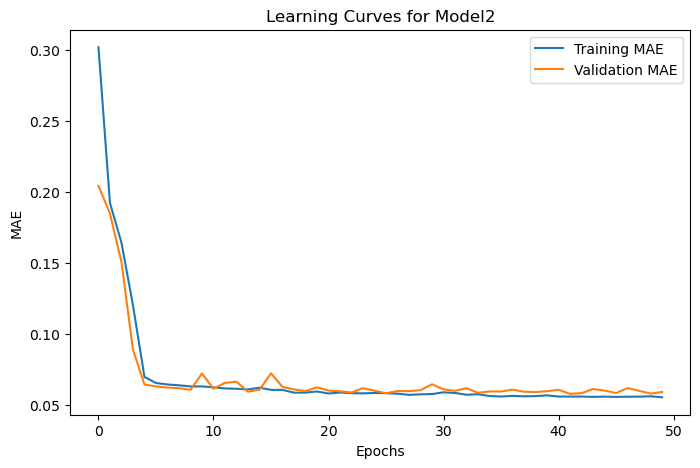

In [18]:
# Train the model 2
history2 = train_model(model2, train_ds_model2, val_ds_model2, epochs=50)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

2024-10-25 00:47:15.017379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Test MAE: 0.0638


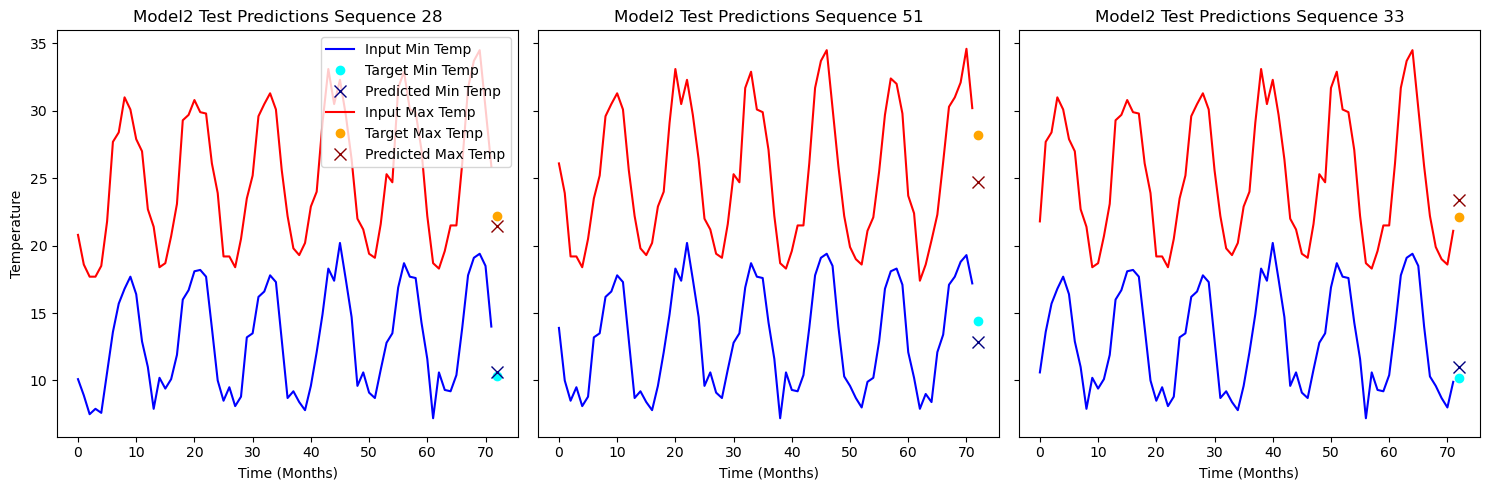

In [19]:
# Evaluate the model on the test dataset
test_mae2 = evaluate_and_visualize(model2, test_ds_model2, num_samples=3, model_type='model2a')


## Model 2 Subtask

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-10-25 00:47:15.476173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test MAE: 0.0708


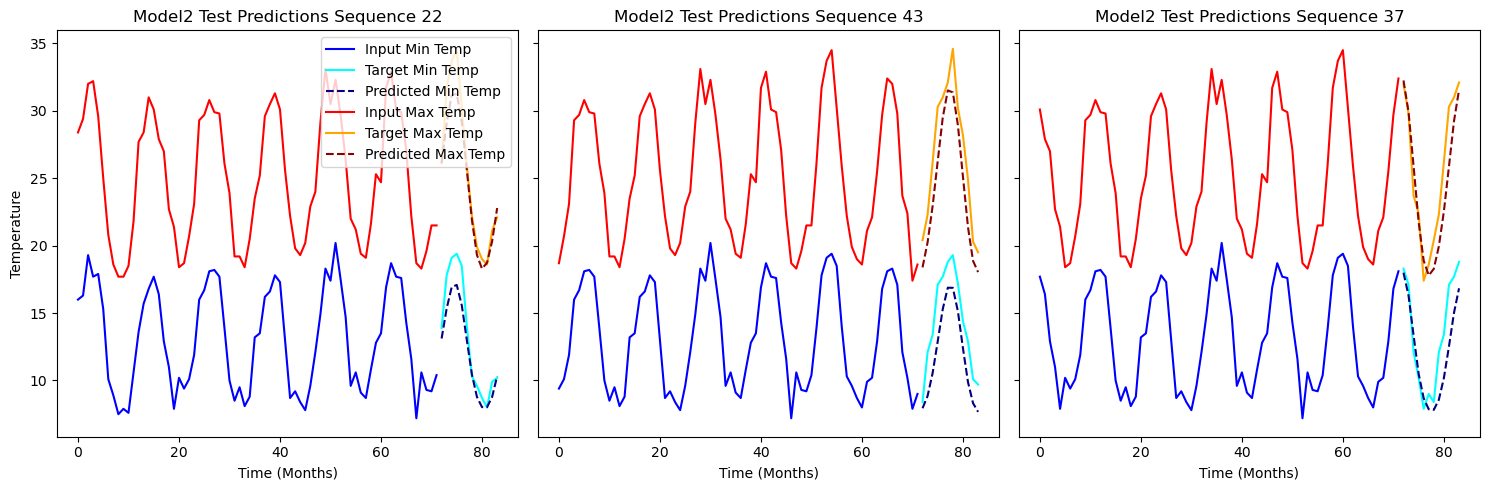

In [20]:
# Evaluate Model 2 on test_ds from Model 1
test_mae2_extended = evaluate_and_visualize(model2, test_ds, num_samples=3, model_type='model2b')

# MODEL 3

In [21]:
def prepare_encoder_decoder_data(df, input_length, target_length, batch_size=32, shuffle=True, seed=42):
    """
    Prepares data for the Encoder-Decoder model.

    Parameters:
    - df: DataFrame containing the temperature data.
    - input_length: Length of input sequences for the Encoder.
    - target_length: Length of target sequences for the Decoder.
    - batch_size: Batch size for the dataset.
    - shuffle: Whether to shuffle the dataset.
    - seed: Seed for shuffling.

    Returns:
    - dataset: TensorFlow dataset yielding (encoder_input, decoder_input), decoder_target tuples.
    """
    if batch_size == -1:
        batch_size = df.shape[0]

    # Create sequences of total_length
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=tf.convert_to_tensor(df, dtype=tf.float32),
        targets=None,
        sequence_length=input_length + target_length,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
        seed=seed
    )

    def split_encoder_decoder(sequence):
        encoder_input = sequence[:, :input_length, :]  # Shape: (batch_size, input_length, num_features)
        decoder_target = sequence[:, input_length:, :]  # Shape: (batch_size, target_length, num_features)

        # Prepare decoder_input by shifting decoder_target and adding start token
        # For simplicity, we can use zeros as start token or the last time step of encoder_input
        start_token = tf.zeros_like(decoder_target[:, :1, :])  # Shape: (batch_size, 1, num_features)
        decoder_input = tf.concat([start_token, decoder_target[:, :-1, :]], axis=1)
        
        return (encoder_input, decoder_input), decoder_target

    dataset = dataset.map(split_encoder_decoder)
    return dataset


In [22]:
def build_encoder_decoder_model(input_length, target_length, num_features, units=16):
    # Encoder
    encoder_inputs = Input(shape=(input_length, num_features))
    encoder_gru1 = GRU(units, return_sequences=True, return_state=True, activation='tanh')
    encoder_outputs1, state_h1 = encoder_gru1(encoder_inputs)
    encoder_gru2 = GRU(units, return_sequences=False, return_state=True, activation='tanh')
    encoder_outputs2, state_h2 = encoder_gru2(encoder_outputs1)
    encoder_states = [state_h1, state_h2]
    
    # Decoder
    decoder_inputs = Input(shape=(None, num_features))  # Allow variable sequence length
    decoder_gru1 = GRU(units, return_sequences=True, return_state=True, activation='tanh')
    decoder_outputs1, _ = decoder_gru1(decoder_inputs, initial_state=state_h1)
    decoder_gru2 = GRU(units, return_sequences=True, return_state=True, activation='tanh')
    decoder_outputs2, _ = decoder_gru2(decoder_outputs1, initial_state=state_h2)
    decoder_dense = Dense(num_features, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs2)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name=f'Model3')
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    # Return the components needed for inference
    return model, encoder_inputs, encoder_states, decoder_inputs, decoder_gru1, decoder_gru2, decoder_dense


In [23]:
# Define input and target lengths
input_length_model3 = 72
target_length_model3 = 12
num_features = 2

# Prepare datasets
train_ds_model3 = prepare_encoder_decoder_data(PerthA_df_scaled, input_length_model3, target_length_model3, batch_size=32, shuffle=True)
val_ds_model3 = prepare_encoder_decoder_data(PerthM_df_scaled.loc['1994-01':'2013-12'], input_length_model3, target_length_model3, batch_size=-1, shuffle=False)
test_ds_model3 = prepare_encoder_decoder_data(PerthM_df_scaled.loc['2014-01':], input_length_model3, target_length_model3, batch_size=-1, shuffle=False)

# Build the model
model3, encoder_inputs, encoder_states, decoder_inputs, decoder_gru1, decoder_gru2, decoder_dense = build_encoder_decoder_model(input_length, target_length, num_features, units=16)

# Print model summary
model3.summary()

Model: "Model3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ [(None, 72, 16),  │        960 │ input_layer_2[0]… │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ [(None, None,     │        960 │ input_layer_3[0]… │
│                     │ 16), (None, 16)]  │            │ gru_4[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 16),      │      1,632 │ gru_4[0][0]       │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ [(None, None,     │      1,632 │ gru_6[0][0],      │
│                     │ 16), (None, 16)]  │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 2)   │         34 │ gru_7[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,218 (20.38 KB)

 Trainable params: 5,218 (20.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.3033 - mae: 0.3033 - val_loss: 0.2221 - val_mae: 0.2221
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2143 - mae: 0.2143 - val_loss: 0.2006 - val_mae: 0.2006
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1917 - mae: 0.1917 - val_loss: 0.1723 - val_mae: 0.1723
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1607 - mae: 0.1607 - val_loss: 0.1207 - val_mae: 0.1207
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1087 - mae: 0.1087 - val_loss: 0.0738 - val_mae: 0.0738
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0782 - mae: 0.0782 - val_loss: 0.0662 - val_mae: 0.0662
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0689 - mae: 0.0689 - val_loss: 0.0637 - val_mae: 0.0637
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0653 - mae: 0.0653 - val_loss: 0.0626 - val_mae: 0.0626
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.064

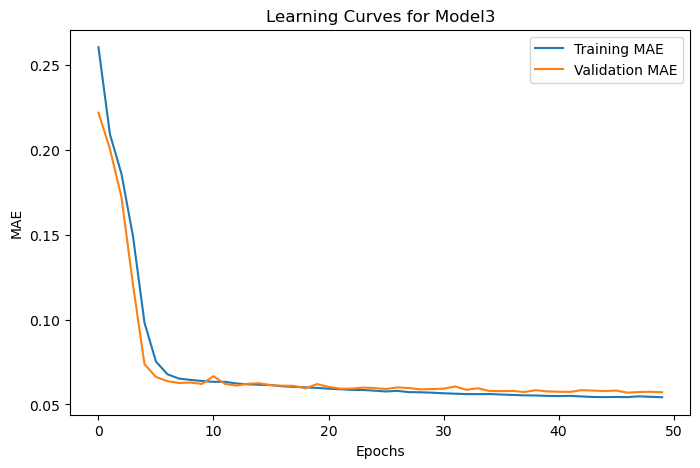

In [24]:
history3 = train_model(model3, train_ds_model3, val_ds_model3, epochs=50)

In [25]:
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

units = 16
# Define decoder inputs for inference
decoder_state_input_h1 = Input(shape=(units,))
decoder_state_input_h2 = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_h2]

# Reuse the decoder GRU layers and dense layer
decoder_outputs1, state_h1 = decoder_gru1(decoder_inputs, initial_state=decoder_state_input_h1)
decoder_outputs2, state_h2 = decoder_gru2(decoder_outputs1, initial_state=decoder_state_input_h2)
decoder_states = [state_h1, state_h2]

decoder_outputs = decoder_dense(decoder_outputs2)

# Decoder model for inference
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1
    target_seq = np.zeros((input_seq.shape[0], 1, num_features))
    # Optionally, set the start token (e.g., last time step of the encoder input)
    # target_seq[:, 0, :] = input_seq[:, -1, :]
    
    # Collect predictions
    decoded_seq = []
    
    for _ in range(target_length):
        output_tokens, h1, h2 = decoder_model.predict([target_seq] + states_value)
        
        # Append the prediction
        decoded_seq.append(output_tokens)
        
        # Update target sequence (next decoder input)
        target_seq = output_tokens  # Use the last prediction as input
        
        # Update states
        states_value = [h1, h2]
    
    decoded_seq = np.concatenate(decoded_seq, axis=1)
    return decoded_seq


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

2024-10-25 00:47:45.326118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepWARNING:tensorflow:5 out of the last 26 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x306fe2a20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━

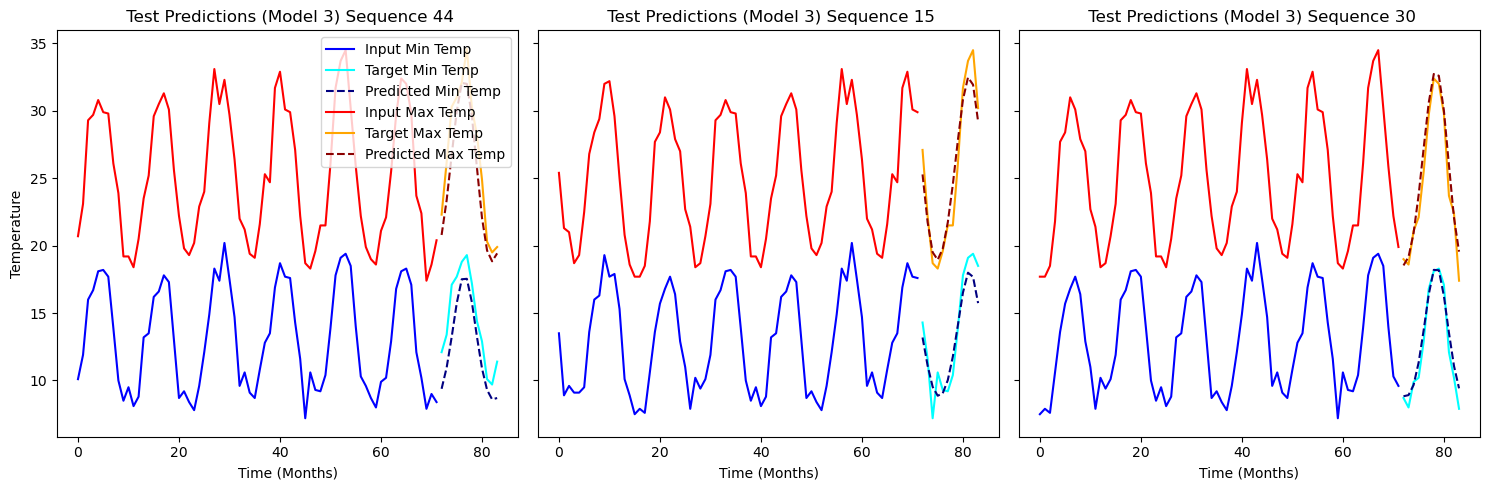

In [27]:
# Extract encoder inputs and decoder targets from the test dataset
encoder_inputs_test = []
decoder_targets_test = []

for inputs, decoder_target_data in test_ds_model3:
    encoder_input_data, decoder_input_data = inputs
    encoder_inputs_test.append(encoder_input_data.numpy())
    decoder_targets_test.append(decoder_target_data.numpy())


encoder_inputs_test = np.concatenate(encoder_inputs_test, axis=0)
decoder_targets_test = np.concatenate(decoder_targets_test, axis=0)

# Make predictions
y_pred = decode_sequence(encoder_inputs_test)

# Evaluate MAE
test_mae = np.mean(np.abs(decoder_targets_test - y_pred))
print(f"Test MAE: {test_mae:.4f}")

# Visualize predictions
display_temperatures(
    encoder_inputs_test, decoder_targets_test, predicted=y_pred, num_samples=3,
    title_prefix='Test Predictions (Model 3)', inverse_scaler=scaler)
